In [1]:
# How to engineer factors using pandas and NumPy

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from talib import RSI, BBANDS


In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
chapterData = pd.read_csv('MLratios_vals_money.csv',
                          index_col=['Year','Ticker'],
                          parse_dates=True,
                          infer_datetime_format=True)
                          

In [5]:
chapterDataYearlyPrices = pd.DataFrame(chapterData.Close)


chapterDataYearlyPrices

,,Close
Year,Ticker,
2015-01-01,A,39.602
2016-01-01,A,43.370
2017-01-01,A,59.330
2018-01-01,A,67.169
2019-01-01,A,75.212
...,...,...
2015-01-01,ZYXI,0.194
2016-01-01,ZYXI,0.295
2017-01-01,ZYXI,1.117


In [6]:
"""
# How to compute return for multiple historical periods.
To capture time-series dynamics like momentum patterns,
we compute historical multiperiod return using the pct_change(n_periods) method, where n_periods indentifies the num of lags.
We then convert the wide result back into long format using .stack(), use .pipe() to apply .clip() method to the resulting DataFrame,
and winsorize returns at the [1%, 99%] levels; that is, we cap outliers these percentiles,

Finally, we obtain the compounded monthly returns over change the order of the MultiIndex levels,
we obtain the compounded monthly returns over six different periods, ranging form 1 to 12 months:
"""



outliner_cutoff = 0.01

data = pd.DataFrame()

lags = [1, 2, 3, 6, 9, 12]

for lag in lags:
    data[f'return_{lag}Year'] = (chapterDataYearlyPrices
                              .pct_change(lag)
                              .stack()
                              .pipe(lambda x:
                                    x.clip(lower=x.quantile(outliner_cutoff),
                                           upper=x.quantile(1-outliner_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1)
                             )
    data = data.swaplevel()
    
    data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9079 entries, (Timestamp('2016-01-01 00:00:00'), 'Close', 'A') to (Timestamp('2019-01-01 00:00:00'), 'Close', 'ZYXI')
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   return_1Year  9079 non-null   float64
dtypes: float64(1)
memory usage: 187.7+ KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9079 entries, (Timestamp('2016-01-01 00:00:00'), 'A', 'Close') to (Timestamp('2019-01-01 00:00:00'), 'ZYXI', 'Close')
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   return_1Year  9079 non-null   float64
 1   return_2Year  0 non-null      float64
dtypes: float64(2)
memory usage: 258.6+ KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9079 entries, (Timestamp('2016-01-01 00:00:00'), 'Close', 'A') to (Timestamp('2019-01-01 00:00:00'), 'Close', 'ZYXI')
Data columns (total 3 columns):
 #   Column  

In [7]:
data

,,,return_1Year,return_2Year,return_3Year,return_6Year,return_9Year,return_12Year
Year,Ticker,,,,,,,
2016-01-01,A,Close,0.095147,NaN,NaN,NaN,NaN,NaN
2017-01-01,A,Close,0.367996,NaN,NaN,NaN,NaN,NaN
2018-01-01,A,Close,0.132125,NaN,0.192570,NaN,NaN,NaN
2019-01-01,A,Close,0.119743,NaN,0.201432,NaN,NaN,NaN
2016-01-01,AA,Close,-0.609597,NaN,-0.209002,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-01-01,ZYXI,Close,-0.962981,NaN,-0.767470,NaN,-0.391212,NaN
2016-01-01,ZYXI,Close,0.520619,NaN,-0.674259,NaN,-0.384984,NaN
2017-01-01,ZYXI,Close,2.786441,NaN,-0.494802,NaN,-0.285833,NaN


In [8]:
# We can use these resluts to compute momentum factors on the difference betweeen returns over longer periods and the most recent montly return,
# as well as well as for the difference betwwen 3- and 12-month returns, as follows

for lag in [2, 3, 6, 9, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}Year'].sub(data.return_1Year)
data[f'momentum_3_12'] = data[f'return_12Year'].sub(data.return_3Year)


In [9]:
data

,,,return_1Year,return_2Year,return_3Year,return_6Year,return_9Year,return_12Year,momentum_2,momentum_3,momentum_6,momentum_9,momentum_12,momentum_3_12
Year,Ticker,,,,,,,,,,,,,
2016-01-01,A,Close,0.095147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,A,Close,0.367996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,A,Close,0.132125,NaN,0.192570,NaN,NaN,NaN,NaN,0.060445,NaN,NaN,NaN,NaN
2019-01-01,A,Close,0.119743,NaN,0.201432,NaN,NaN,NaN,NaN,0.081689,NaN,NaN,NaN,NaN
2016-01-01,AA,Close,-0.609597,NaN,-0.209002,NaN,NaN,NaN,NaN,0.400595,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,ZYXI,Close,-0.962981,NaN,-0.767470,NaN,-0.391212,NaN,NaN,0.195511,NaN,0.571769,NaN,NaN
2016-01-01,ZYXI,Close,0.520619,NaN,-0.674259,NaN,-0.384984,NaN,NaN,-1.194877,NaN,-0.905603,NaN,NaN
2017-01-01,ZYXI,Close,2.786441,NaN,-0.494802,NaN,-0.285833,NaN,NaN,-3.281243,NaN,-3.072274,NaN,NaN


In [10]:

""" To compute returns for various holding periods,
we used the normalized perios returns computed previously and shift them back to alogn them with current financial features"""

for t in [1, 2,3,6,12]:
    data[f'target_{t}Year'] = (data.groupby(level='Ticker')
                                         [f'return_{t}Year'].shift(-t))

In [11]:
"""
Computing factor betas:

We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression in chapter 7

The five Fama-French factors, namely market risk, size, value, operationg profitability, and invesment, have been shown to explain asset returns. 

They are commonly used to assess the exposure of a poftfolio to well-known drivers of risk and returns, where the enexplained portion is then attributed
to the managers idiosyncratic skill. Hence, it is natural to include past facotr exposures as financial features in models that aim to predict retrns.

"""


factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

fac_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench', start='2015')[0].drop("RF", axis=1)

fac_data.index = fac_data.index.to_timestamp()

fac_data = fac_data.resample("M").last().div(100)
           
fac_data.index.name = 'Year'



In [12]:


fac_data

,Mkt-RF,SMB,HML,RMW,CMA
Year,,,,,
2015-01-31,-0.0311,-0.0090,-0.0361,0.0164,-0.0168
2015-02-28,0.0613,0.0030,-0.0186,-0.0112,-0.0178
2015-03-31,-0.0112,0.0310,-0.0041,0.0015,-0.0054
2015-04-30,0.0059,-0.0307,0.0183,0.0001,-0.0064
2015-05-31,0.0136,0.0082,-0.0112,-0.0177,-0.0072
...,...,...,...,...,...
2021-06-30,0.0275,-0.0025,-0.0776,-0.0214,-0.0099
2021-07-31,0.0127,-0.0456,-0.0175,0.0536,-0.0055
2021-08-31,0.0290,-0.0079,-0.0013,-0.0025,-0.0167


In [13]:
T = 24

betas = (fac_data
         .groupby(level='ticker'

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_18936/3812526399.py, line 4)

In [ ]:
#fac_dataJoined = fac_data.join(data['return_1Year']).sort_index()


In [14]:
EndchapterData = pd.read_csv("equity_trades_only_1min_adj.csv",
                          index_col= ['Date'],
                          parse_dates=True,
                          infer_datetime_format=True)

EndchapterData

,SecId,Ticker,TimeBarStart,FirstTradePrice,HighTradePrice,LowTradePrice,LastTradePrice,VolumeWeightPrice,Volume,TotalTrades,FirstTradePriceAdjusted,HighTradePriceAdjusted,LowTradePriceAdjusted,LastTradePriceAdjusted,VolumeWeightPriceAdjusted,VolumeAdjusted
Date,,,,,,,,,,,,,,,,
2020-01-28,33449,AAPL,04:00,312.60,312.60,311.10,311.20,311.48600,1443,16,77.6145,77.6145,77.2421,77.2669,77.33795,5772
2020-01-28,33449,AAPL,04:01,311.01,311.07,310.43,310.43,310.57852,2627,31,77.2198,77.2347,77.0758,77.0758,77.11264,10508
2020-01-28,33449,AAPL,04:02,310.33,310.33,310.30,310.33,310.31814,253,7,77.0509,77.0509,77.0435,77.0509,77.04799,1012
2020-01-28,33449,AAPL,04:03,310.33,310.85,310.33,310.73,310.72091,220,3,77.0509,77.1800,77.0509,77.1502,77.14799,880
2020-01-28,33449,AAPL,04:04,310.50,310.68,310.41,310.68,310.42950,240,6,77.0931,77.1378,77.0708,77.1378,77.07564,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-28,33449,AAPL,19:55,322.49,322.55,322.40,322.40,322.46887,5500,56,80.0701,80.0850,80.0478,80.0478,80.06486,22000
2020-01-28,33449,AAPL,19:56,322.46,322.50,322.32,322.32,322.42040,5503,52,80.0627,80.0726,80.0279,80.0279,80.05282,22012
2020-01-28,33449,AAPL,19:57,322.32,322.50,322.25,322.32,322.36762,2589,39,80.0279,80.0726,80.0105,80.0279,80.03972,10356


In [15]:
up, mid, low = BBANDS(EndchapterData['LastTradePrice'], timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

In [20]:
rsi = RSI(EndchapterData['HighTradePrice'], timeperiod=14)

In [38]:
TechnicalFactors_data = pd.DataFrame({'AAPL': EndchapterData['LastTradePrice'], 'BB Up': up, 'BB Mid': mid, "BB down": low, 'RSI': rsi})

TechnicalFactors_data.dropna(axis=0 , inplace=True)

<AxesSubplot:title={'center':'Relative Strength Index'}, xlabel='Date'>

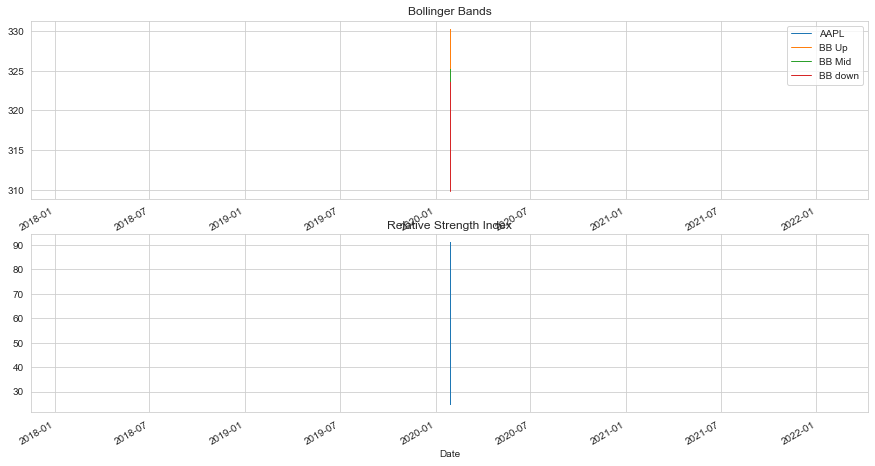

In [43]:
fig, axes= plt.subplots(nrows=2, figsize=(15, 8))

TechnicalFactors_data.drop("RSI", axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')

TechnicalFactors_data["RSI"].plot(ax=axes[1], lw=1, title='Relative Strength Index')

In [34]:


#axes[0].axline(70, lw=1, ls='--', c='k')

#axes[1].axline(30, lw=1, ls='--', c='k')

<AxesSubplot:title={'center':'Relative Strength Index'}, xlabel='Date'>